In [1]:
import numpy as np
import string
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show();

## Data preprocessing

In [ ]:
# Mounting the google drive to google colab in order to load the data files directly from it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We load a dataset build from Europarl dataset (containing the proceedings from the European Parliament in different languages). We will use a cleaned version of both english and french sentences (each sentence english sentence sharing the same meaning as corresponding french one)

In [ ]:
import pickle
with open(f'/content/drive/MyDrive/EPITA_NLP/Course3/english.pkl', 'rb') as f:
    data_eng = pickle.load(f)
df_eng = pd.DataFrame(data_eng)

with open(f'/content/drive/MyDrive/EPITA_NLP/Course3/french.pkl', 'rb') as f:
    data_fren = pickle.load(f)
df_fren = pd.DataFrame(data_fren)

We can have a look on the english dataset

In [ ]:
df_eng

,0
0,resumption of the session
1,i declare resumed the session of the european ...
2,although as you will have seen the dreaded mil...
3,you have requested a debate on this subject in...
4,in the meantime i should like to observe a min...
...,...
2007718,i would also like although they are absent to ...
2007719,i am not going to reopen the millennium or not...
2007720,adjournment of the session
2007721,i declare the session of the european parliame...


As well as on the French dataset

In [ ]:
df_fren

,0
0,reprise de la session
1,je declare reprise la session du parlement eur...
2,comme vous avez pu le constater le grand bogue...
3,vous avez souhaite un debat a ce sujet dans le...
4,en attendant je souhaiterais comme un certain ...
...,...
2007718,je me permettrai meme bien quils soient absent...
2007719,je ne rouvrirai pas le debat sur le millenaire...
2007720,interruption de la session
2007721,je declare interrompue la session du parlement...


We can check both datasets correspond to the same sentences in both languages.

(You can see that the cleaning step had some impacts on some French words, especially concerning the accents which have been removed. Anyway, this is not a big problem here since we do not use a pre-trained model for language understanding, we use these French sentences as references for training a model from scratch)

In [ ]:
for en_sent, fr_sent in list(zip(df_eng[0],df_fren[0]))[0:3]:
  print(f"English: {en_sent}")
  print(f"French: {fr_sent}")
  print("---------------------")

English: resumption of the session
French: reprise de la session
---------------------
English: i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period
French: je declare reprise la session du parlement europeen qui avait ete interrompue le vendredi decembre dernier et je vous renouvelle tous mes vux en esperant que vous avez passe de bonnes vacances
---------------------
English: although as you will have seen the dreaded millennium bug failed to materialise still the people in a number of countries suffered a series of natural disasters that truly were dreadful
French: comme vous avez pu le constater le grand bogue de lan ne sest pas produit en revanche les citoyens dun certain nombre de nos pays ont ete victimes de catastrophes naturelles qui ont vraiment ete terribles
---------------------


We define the Tokenizer object for both languages, and we get the size of vacabulary found in each.

We also define the size of the sequences we want to use for training (we can keep a reduce length to speed up training)

In [ ]:
# prepare english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df_eng[0][:50000])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('Size of English Vocabulary : %d' % eng_vocab_size)
# prepare French tokenizer
fren_tokenizer = Tokenizer()
fren_tokenizer.fit_on_texts(df_fren[0][:50000])
fren_vocab_size = len(fren_tokenizer.word_index) + 1
fren_length = 8
print('Size of French Vocabulary : %d' % fren_vocab_size)

Size of English Vocabulary : 21424
Size of French Vocabulary : 31816


We transform the text sentences into token sequences.

We also add zero-padding for each of those sequences. Since we consider rather small length, most of the time the sequences will be troncated instead of being completed with additional zeros)

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in df_eng[0][:5000]:
	token_list = eng_tokenizer.texts_to_sequences([line])[0]
	input_sequences.append(token_list)


# pad sequences 
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_eng = np.array(pad_sequences(input_sequences, maxlen=eng_length, padding='post'))

For the fist sentence of the dataset, we can see the padded-zeros in the end

In [ ]:
print(f"sentence => {df_eng[0][0]}")
print(f"token sequence => {input_sequences_eng[0]}")
print(f"sequence length => {len(input_sequences_eng[0])}")

sentence => resumption of the session
token sequence => [4421    2    1 1297    0    0    0    0]
sequence length => 8


For the others, most of the time, the sequence is troncated. Anyway, you can check that the length of the **padded sequence** is always the same.

In [ ]:
print(f"sentence => {df_eng[0][1]}")
print(f"token sequence => {input_sequences_eng[1]}")
print(f"sequence length => {len(input_sequences_eng[1])}")

sentence => i declare resumed the session of the european parliament adjourned on friday december and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period
token sequence => [  193     8    39  4148     7  6707 11174   447]
sequence length => 8


We do the exact same processing but this time to turn the **French** sentences into padded token sequences.

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in df_fren[0][:5000]:
	token_list = fren_tokenizer.texts_to_sequences([line])[0]
	input_sequences.append(token_list)


# pad sequences 
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_fren = np.array(pad_sequences(input_sequences, maxlen=fren_length, padding='post'))

In [ ]:
input_sequences_fren[0]

array([1321,    1,    2, 1062,    0,    0,    0,    0], dtype=int32)

In [ ]:
fren_vocab_size

31816

## Neural network model definition

Build a neural network using at least one LSTM layer

(you may have a look at https://keras.io/api/layers/)


In [ ]:
model = Sequential()
model.add(Embedding(eng_vocab_size, 512, input_length=eng_length, mask_zero=True))
model.add(LSTM(512))
#------------------------- Choose either the RepeatVector of the Bidirectional
model.add(RepeatVector(fren_length))
#model.add(Bidirectional(LSTM(fren_length), return_sequences = True))
#----------------------------
model.add(LSTM(512, return_sequences=True))
model.add(Dense(fren_vocab_size, activation='softmax'))


rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            10969088  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 31816)          16321608  
Total params: 31,489,096
Trainable params: 31,489,096
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x = input_sequences_eng, y = input_sequences_fren, epochs = 50, batch_size= 100, validation_split=0.25)

Epoch 1/50
38/38 [==============================] - 127s 3s/step - loss: 8.2551 - accuracy: 0.0498 - val_loss: 7.2106 - val_accuracy: 0.0705
Epoch 2/50
38/38 [==============================] - 102s 3s/step - loss: 6.7074 - accuracy: 0.0705 - val_loss: 7.2710 - val_accuracy: 0.0762
Epoch 3/50
38/38 [==============================] - 102s 3s/step - loss: 6.5486 - accuracy: 0.0765 - val_loss: 7.3394 - val_accuracy: 0.0794
Epoch 4/50
38/38 [==============================] - 104s 3s/step - loss: 6.4715 - accuracy: 0.0798 - val_loss: 7.3646 - val_accuracy: 0.0797
Epoch 5/50
38/38 [==============================] - 103s 3s/step - loss: 6.4281 - accuracy: 0.0783 - val_loss: 7.4676 - val_accuracy: 0.0798
Epoch 6/50
38/38 [==============================] - 102s 3s/step - loss: 6.3734 - accuracy: 0.0759 - val_loss: 7.2793 - val_accuracy: 0.0801
Epoch 7/50
38/38 [==============================] - 102s 3s/step - loss: 6.2729 - accuracy: 0.0817 - val_loss: 7.3383 - val_accuracy: 0.0808
Epoch 8/50
38

In [ ]:
model.predict_classes(input_sequences_eng[0].reshape(1,8), verbose=0)

array([[1321,    2,    2, 1062,    0,    0,    0,    0]])

In [ ]:
input_sequences_eng[0].shape

(8,)

We can define an English sentence to be translated into French thanks to the model trained

In [ ]:
input_sentence = "The session is finished"
token_list_test = eng_tokenizer.texts_to_sequences([input_sentence])[0]


# pad sequences 
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_eng_test = np.array(pad_sequences([token_list_test], maxlen=eng_length, padding='post'))

We compute the translation

In [ ]:
input_sequences_eng_test
predicted = model.predict_classes(input_sequences_eng_test, verbose=0)
output_words = ""
for token_predicted in predicted[0]:
  for word, index in fren_tokenizer.word_index.items():
    if index == token_predicted:
      output_words += word+" "
      break
print(output_words)

le societe la 


## Result visualization

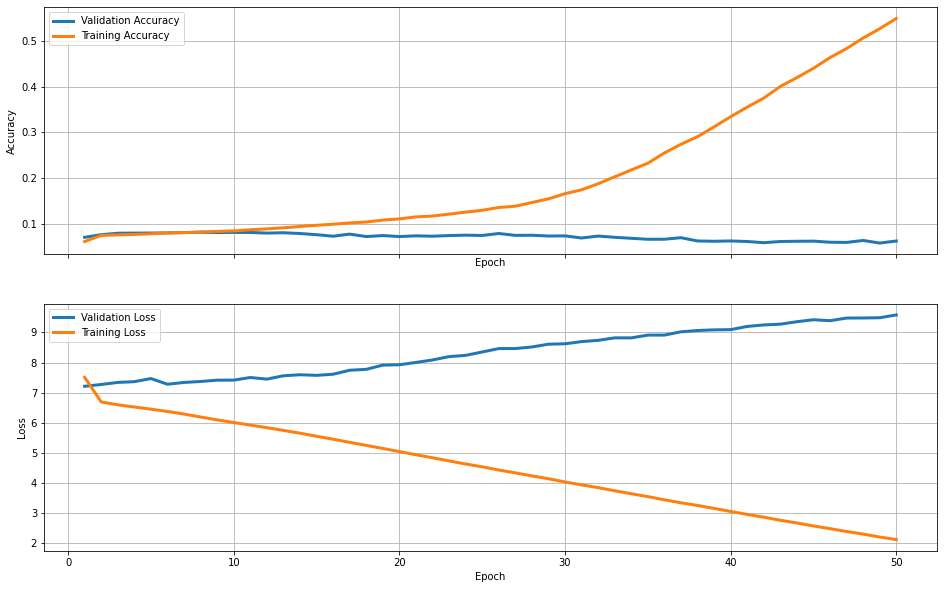

In [ ]:
plot_results(history)

References:

https://medium.com/@saikrishna4820/lstm-language-translation-18c076860b23

https://machinelearningmastery.com/prepare-french-english-dataset-machine-translation/
